# Overcomplete Autoencoders with PyTorch

!!! tip "Run Jupyter Notebook"
    You can run the code for this section in this [jupyter notebook link](https://github.com/ritchieng/deep-learning-wizard/blob/master/docs/deep_learning/practical_pytorch/pytorch_fc_overcomplete_ae.ipynb).

## Introduction
- Recap!
    - An autoencoder's purpose is to learn an approximation of the identity function (mapping $x$ to $\hat x$).
        - Essentially we are trying to learn a function that can take our input $x$ and recreate it $\hat x$.
            - Technically we can do an exact recreation of our in-sample input if we use a very wide and deep neural network.
- In this particular tutorial, we will be covering denoising autoencoder through overcomplete encoders. 
    - Essentially given noisy images, you can denoise and make them less noisy with this tutorial through overcomplete encoders.

![](./images/autoencoder_0.png)


## Fashion MNIST Dataset Exploration

### Imports

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
figsize=(15, 6)
plt.style.use('fivethirtyeight')


| Name  | Content | Examples | Size | Link | MD5 Checksum|
| --- | --- |--- | --- |--- |--- |
| `train-images-idx3-ubyte.gz`  | training set images  | 60,000|26 MBytes | [Download](http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz)|`8d4fb7e6c68d591d4c3dfef9ec88bf0d`|
| `train-labels-idx1-ubyte.gz`  | training set labels  |60,000|29 KBytes | [Download](http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz)|`25c81989df183df01b3e8a0aad5dffbe`|
| `t10k-images-idx3-ubyte.gz`  | test set images  | 10,000|4.3 MBytes | [Download](http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz)|`bef4ecab320f06d8554ea6380940ec79`|
| `t10k-labels-idx1-ubyte.gz`  | test set labels  | 10,000| 5.1 KBytes | [Download](http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz)|`bb300cfdad3c16e7a12a480ee83cd310`|

### Load Dataset (Step 1)
- Typically we've been leveraging on `dsets.MNIST()`, now we simply change to `dsets.FashionMNIST`!

In [5]:
# Fashion-MNIST data loader
train_dataset = dsets.FashionMNIST(root='./data',
                                   train=True,
                                   transform=transforms.ToTensor(),
                                   download=True)

test_dataset = dsets.FashionMNIST(root='./data',
                                  train=False,
                                  transform=transforms.ToTensor())

Processing...
Done!


### Load Data Loader (Step 2)

In [6]:
# Batch size, iterations and epochs
batch_size = 100
n_iters = 5000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

### Labels
Each training and test example is assigned to one of the following labels:

| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |


#### Sample: Boot

Label 9


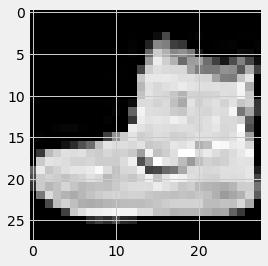

In [7]:
# Sample 0: boot
sample_num = 0
show_img = train_dataset[sample_num][0].numpy().reshape(28, 28)
label = train_dataset[sample_num][1]
print(f'Label {label}')
plt.imshow(show_img, cmap='gray');

#### Sample: shirt

Label 0


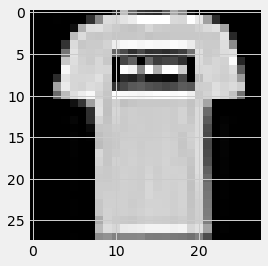

In [8]:
# Sample 1: shirt
sample_num = 1
show_img = train_dataset[sample_num][0].numpy().reshape(28, 28)
label = train_dataset[sample_num][1]
print(f'Label {label}')
plt.imshow(show_img, cmap='gray');

#### Sample: dress

Label 3


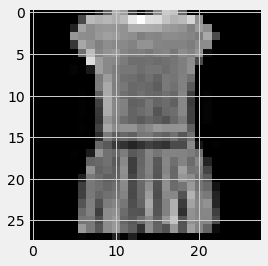

In [9]:
# Sample 3: dress
sample_num = 3
show_img = train_dataset[sample_num][0].numpy().reshape(28, 28)
label = train_dataset[sample_num][1]
print(f'Label {label}')
plt.imshow(show_img, cmap='gray');

#### Maximum/minimum pixel values
- Pixel values range from 0 to 1

In [10]:
min_pixel_value = train_dataset[sample_num][0].min()
max_pixel_value = train_dataset[sample_num][0].max()

print(f'Minimum pixel value: {min_pixel_value}')
print(f'Maximum pixel value: {max_pixel_value}')

Minimum pixel value: 0.0
Maximum pixel value: 1.0


## Overcomplete Autoencoder

### Sigmoid Function
- Sigmoid function was introduced earlier, where the function allows to bound our output from 0 to 1 inclusive given our input.
- This is introduced and clarified here as we would want this in our final layer of our overcomplete autoencoder as we want to bound out final output to the pixels' range of 0 and 1.

Text(0.5, 1.0, 'Sigmoid Function')

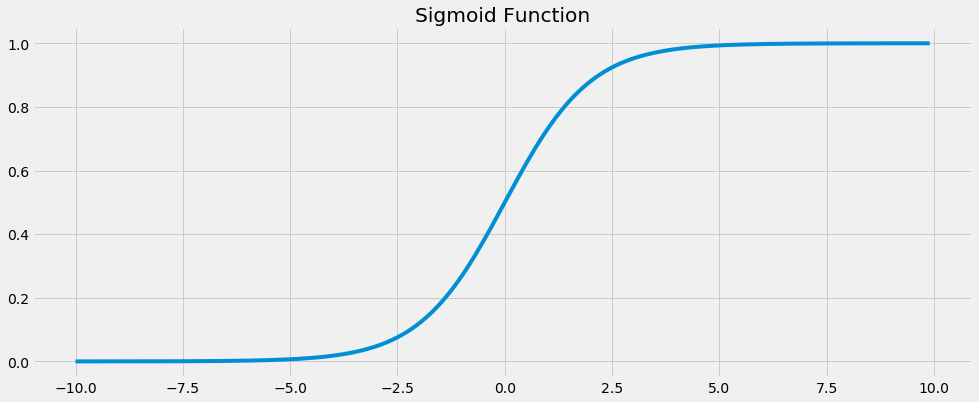

In [11]:
# Sigmoid function has function bounded by min=0 and max=1
# So this will be what we will be using for the final layer's function
x = torch.arange(-10., 10., 0.1)
plt.figure(figsize=figsize);
plt.plot(x.numpy(), torch.sigmoid(x).numpy())
plt.title('Sigmoid Function')

### Steps
- These steps should be familiar by now! Our famous 7 steps. But I will be adding one more step here, Step 8 where we run our inference.
    - Step 1: Load Dataset
    - Step 2: Make Dataset Iterable
    - Step 3: Create Model Class
    - Step 4: Instantiate Model Class
    - Step 5: Instantiate Loss Class
    - Step 6: Instantiate Optimizer Class
    - Step 7: Train Model
    - Step 8: Model Inference

#### Step 3: Create Model Class

In [19]:
# Model definition
class FullyConnectedAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        # Encoder: affine function
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        # Decoder: affine function
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Encoder: affine function
        out = self.fc1(x)
        # Encoder: non-linear function
        out = F.leaky_relu(out)

        # Decoder: affine function
        out = self.fc2(out)
        # Decoder: non-linear function
        out = torch.sigmoid(out)
        
        return out

#### Step 4: Instantiate Model Class

In [20]:
# Dimensions for overcomplete (larger latent representation)
input_dim = 28*28
hidden_dim = int(input_dim * 1.5)
output_dim = input_dim

# Instantiate Fully-connected Autoencoder (FC-AE)
# And assign to model object
model = FullyConnectedAutoencoder(input_dim, hidden_dim, output_dim)

#### Step 5: Instantiate Loss Class

In [21]:
# We want to minimize the per pixel reconstruction loss
# So we've to use the mean squared error (MSE) loss
# This is similar to our regression tasks' loss
criterion = nn.MSELoss()

#### Step 6: Instantiate Optimizer Class

In [22]:
# Using basic Adam optimizer
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

##### Inspect Parameter Groups

In [23]:
# Parameter inspection
num_params_group = len(list(model.parameters()))
for group_idx in range(num_params_group):
    print(list(model.parameters())[group_idx].size())

torch.Size([1176, 784])
torch.Size([1176])
torch.Size([784, 1176])
torch.Size([784])


#### Step 7: Train Model
- Take note there's a critical line of `dropout = nn.Dropout(0.5)` here which basically allows us to make noisy images from our original Fashion MNIST images.
- It basically drops out 50% of all pixels randomly.

In [24]:
idx = 0

# Dropout for creating noisy images
# by dropping out pixel with a 50% probability
dropout = nn.Dropout(0.5)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Load images with gradient accumulation capabilities
        images = images.view(-1, 28*28).requires_grad_()
        
        # Noisy images
        noisy_images = dropout(torch.ones(images.shape)) * images

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output
        outputs = model(noisy_images)

        # Calculate Loss: MSE Loss based on pixel-to-pixel comparison
        loss = criterion(outputs, images)

        # Getting gradients w.r.t. parameters via backpropagation
        loss.backward()

        # Updating parameters via gradient descent
        optimizer.step()

        idx += 1

        if idx % 500 == 0:
            # Calculate MSE Test Loss
            total_test_loss = 0
            total_samples = 0
            
            # Iterate through test dataset
            for images, labels in test_loader:
                # Noisy images
                noisy_images = dropout(torch.ones(images.shape)) * images
                
                # Forward pass only to get logits/output
                outputs = model(noisy_images.view(-1, 28*28))

                # Test loss
                test_loss = criterion(outputs, images.view(-1, 28*28))

                # Total number of labels
                total_samples += labels.size(0)

                # Total test loss
                total_test_loss += test_loss

            mean_test_loss = total_test_loss / total_samples

            # Print Loss
            print(f'Iteration: {idx}. Average Test Loss: {mean_test_loss.item()}.')

Iteration: 500. Average Test Loss: 0.0001664187147980556.
Iteration: 1000. Average Test Loss: 0.00014121478307060897.
Iteration: 1500. Average Test Loss: 0.0001341506722383201.
Iteration: 2000. Average Test Loss: 0.0001252180663868785.
Iteration: 2500. Average Test Loss: 0.00012206179235363379.
Iteration: 3000. Average Test Loss: 0.00011766648094635457.
Iteration: 3500. Average Test Loss: 0.00011584569438127801.
Iteration: 4000. Average Test Loss: 0.00011396891932236031.
Iteration: 4500. Average Test Loss: 0.00011224475019844249.


#### Model Inference

##### Raw Sample 1

Label 4


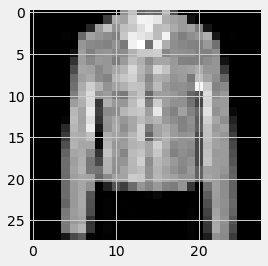

In [31]:
# Test sample: Raw
sample_num = 10
raw_img = test_dataset[sample_num][0]
show_img = raw_img.numpy().reshape(28, 28)
label = test_dataset[sample_num][1]
print(f'Label {label}')
plt.imshow(show_img, cmap='gray');

##### Test Sample 1: Noisy to Denoised

Label 4


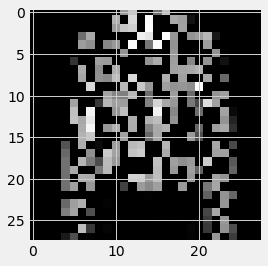

In [36]:
# Test sample: Noisy
sample_num = 10
raw_img = test_dataset[sample_num][0]
noisy_image = dropout(torch.ones(raw_img.shape)) * raw_img
show_img = noisy_image.numpy().reshape(28, 28)
label = test_dataset[sample_num][1]
print(f'Label {label}')
plt.imshow(show_img, cmap='gray');

## Summary
- Introduction
    - Recap of Autoencoders
    - Introduction of denoising autoencoders
- Dataset Exploration
    - Fashion MNIST
        - 10 classes
        - Similar to MNIST but fashion images instead of digits
- **8 Step** Model Building Recap
    - Step 1: Load Dataset
    - Step 2: Make Dataset Iterable
    - Step 3: Create Model Class
    - Step 4: Instantiate Model Class
    - Step 5: Instantiate Loss Class
    - Step 6: Instantiate Optimizer Class
    - Step 7: Train Model
    - Step 8: Model Inference
        - Raw Sample 1
        - Noisy to Denoised Sample 1